<a href="https://colab.research.google.com/github/Aditya270504/Credit-Card-Fraud-Detection-using-Autoencoder/blob/main/Credit_Card_Fraud_Detecdtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.manifold import TSNE

**2. Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')     # Mount Google Drive to access files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Credit Card Fraud Detection/creditcard.csv')
data = df.copy()      # Create a copy for processing
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**3. Exploratory Data Analysis**

In [ ]:
data.shape

(284807, 31)

In [ ]:
class_counts = data.groupby(['Class']).size()     # Group data by 'Class' and count entries
class_counts

,0
Class,
0,284315
1,492


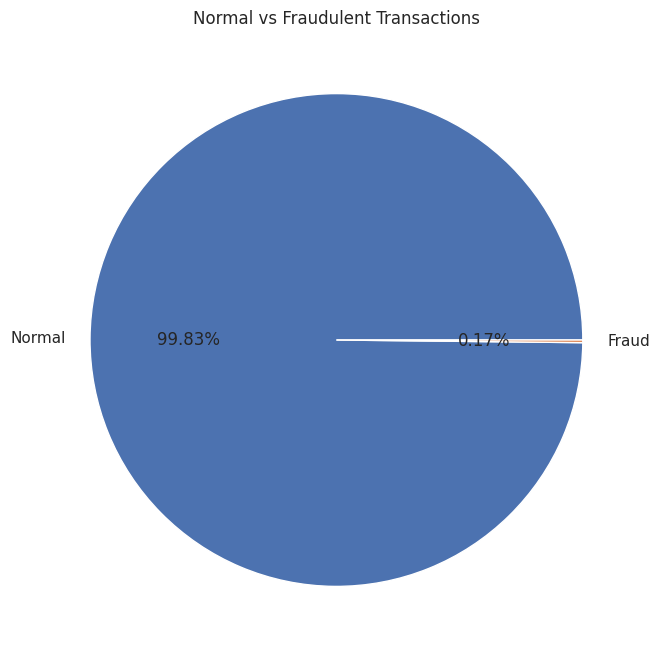

In [ ]:
# Plot pie chart to show class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index.map({0: 'Normal', 1: 'Fraud'}), autopct='%1.2f%%', colors=sns.color_palette("deep", len(class_counts)))
plt.ylabel('')
plt.title('Normal vs Fraudulent Transactions')
plt.show()

**4. Data Sampling**

In [ ]:
normal_transaction = data[data['Class'] == 0].sample(1000)      # Sample 1000 normal transactions
fraud_transaction = data[data['Class'] == 1]      # Include all fraud transactions

In [ ]:
# Combine and shuffle the data
new_data = pd.concat([normal_transaction, fraud_transaction]).sample(frac=1).reset_index(drop=True)

**5. t-SNE Visualization**

In [ ]:
X = new_data.drop(['Class'], axis=1).values     # Features
Y = new_data['Class'].values      # Labels

In [ ]:
# Function to generate t-SNE plot
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Normal Transaction'):
    tsne = TSNE(n_components=2, random_state=24, init='random', learning_rate=200)
    X_t = tsne.fit_transform(X)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[y == 0, 0], X_t[y == 0, 1], color='red', alpha=0.7, label="Normal")
    plt.scatter(X_t[y == 1, 0], X_t[y == 1, 1], color='blue', alpha=0.7, label="Fraud")
    plt.legend(loc='best')
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.savefig(name)
    plt.show()

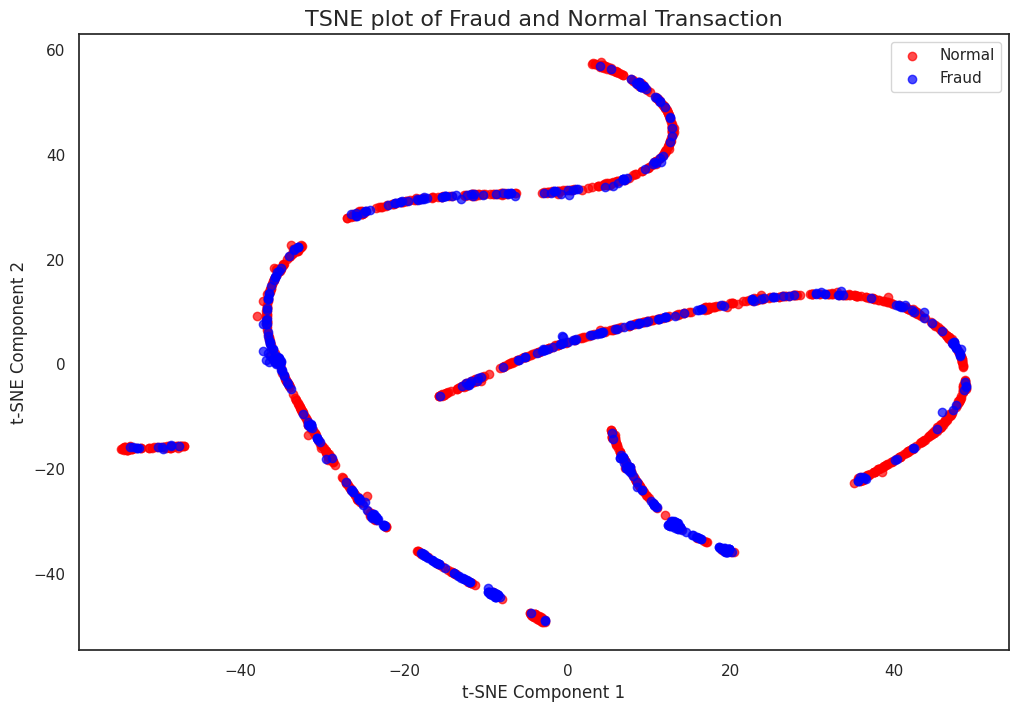

In [ ]:
tsne_plot(X, Y, name="tsne_plot.png")

**6. Data Preprocessing**

In [ ]:
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

In [ ]:
# Standardize 'Amount' and 'Time' for normalization
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))

In [ ]:
normal_data, fraud_data = data[data['Class']==0], data[data['Class']==1]

In [ ]:
# Split into training and testing sets
train_data = normal_data.iloc[:2000, :]
test_data = pd.concat([normal_data.iloc[2000:2608,:], fraud_data.iloc[:, :]], axis =0).sample(frac=1).reset_index(drop=True)

**7. Define Hyperparameters**

In [ ]:
hyper_params = {
    "learning_rate": 0.01,
    "epochs": 150,
    "batch_size": 32,
    "weight_decay": 1e-8,
    'threshold': 0.75
}

**8. Prepare Data for PyTorch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

# Convert training data into PyTorch tensors
train_target = torch.tensor(train_data['Class'].values.astype(np.float32))
train = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = hyper_params['batch_size'], shuffle = True)

In [ ]:
# Convert testing data into PyTorch tensors
test_target = torch.tensor(test_data['Class'].values.astype(np.float32))
test = torch.tensor(test_data.drop('Class', axis = 1).values.astype(np.float32))
test_tensor = data_utils.TensorDataset(test, test_target)
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 1, shuffle = True)

**9. Define Autoencoder Model**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30,15),
            nn.Tanh(),
            nn.Linear(15,7),
            nn.Tanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 15),
            nn.Tanh(),
            nn.Linear(15,30),
            nn.Tanh()
            )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyper_params["learning_rate"],
                             weight_decay=hyper_params['weight_decay'])

**10. Train the Autoencoder**

In [ ]:
# Training loop
for epoch in range(hyper_params['epochs']):
    losses = []
    for (data, _) in train_loader:
        # Forward pass
        output = model(data)
        loss = criterion(output, data)  # Calculate reconstruction loss
        # Backward pass
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()        # Backpropagate the error
        optimizer.step()       # Update the model parameters
        losses.append(loss.detach().cpu().numpy())  # Save the loss value

    # Print training loss
    avg_train_loss = np.mean(losses)
    print(f"Epoch [{epoch+1}/{hyper_params['epochs']}], Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    losses = []
    labels = []
    preds = []
    embeds = []

    for data, label in test_loader:
        # Forward pass
        reconstructed = model(data)  # Forward pass
        loss = torch.sigmoid(criterion(reconstructed, data)).item()  # Compute the loss for validation data
        losses.append(round(loss, 6))  # Append the loss value
        labels.append(label.item())  # Store the true labels
        preds.append(reconstructed[0][-1].item())  # Store the last value of the reconstruction as the prediction
        embeds.append(reconstructed[0][:-1].detach().cpu().numpy())  # Store the embeddings (excluding the last value)

    # Print validation loss
    avg_val_loss = np.mean(losses)
    print(f"Epoch [{epoch+1}/{hyper_params['epochs']}], Testing Loss: {avg_val_loss:.4f}")

    # If it's the final epoch, store results in df1
    if epoch == (hyper_params["epochs"] - 1):
        print("Final predictions for the last epoch:")

        # Create DataFrame (df1)
        df1 = pd.DataFrame()
        df1['Reconstruction_Loss'] = losses
        df1['Labels_gt'] = labels
        df1['Labels_preds'] = [int(x >= hyper_params['threshold']) for x in losses]

        # Display the DataFrame
        print(df1)

print('Training complete')

Epoch [1/150], Training Loss: 0.7091
Epoch [1/150], Testing Loss: 0.7718
Epoch [2/150], Training Loss: 0.5594
Epoch [2/150], Testing Loss: 0.7630
Epoch [3/150], Training Loss: 0.5210
Epoch [3/150], Testing Loss: 0.7606
Epoch [4/150], Training Loss: 0.5073
Epoch [4/150], Testing Loss: 0.7597
Epoch [5/150], Training Loss: 0.5031
Epoch [5/150], Testing Loss: 0.7595
Epoch [6/150], Training Loss: 0.4949
Epoch [6/150], Testing Loss: 0.7589
Epoch [7/150], Training Loss: 0.4927
Epoch [7/150], Testing Loss: 0.7581
Epoch [8/150], Training Loss: 0.4846
Epoch [8/150], Testing Loss: 0.7576
Epoch [9/150], Training Loss: 0.4813
Epoch [9/150], Testing Loss: 0.7577
Epoch [10/150], Training Loss: 0.4811
Epoch [10/150], Testing Loss: 0.7566
Epoch [11/150], Training Loss: 0.4768
Epoch [11/150], Testing Loss: 0.7566
Epoch [12/150], Training Loss: 0.4744
Epoch [12/150], Testing Loss: 0.7573
Epoch [13/150], Training Loss: 0.4787
Epoch [13/150], Testing Loss: 0.7559
Epoch [14/150], Training Loss: 0.4697
Epoch

**11. Evaluation**

In [ ]:
def plot_precision_recall_curves(labels, preds):
    # Calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    # Plot recall vs precision tradeoff
    sns.set(style="white")
    plt.figure(figsize=(12, 8))
    plt.step(recall, precision, color='blue', alpha=0.4, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='purple')
    plt.title('Recall vs Precision', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # Plot precision and recall for different thresholds
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precision[1:], label="Precision", color='red', linewidth=2.5)
    plt.plot(thresholds, recall[1:], label="Recall", color='blue', alpha=0.9, linewidth=2.5)
    plt.title('Precision and Recall for Different Threshold Values', fontsize=16)
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.show()

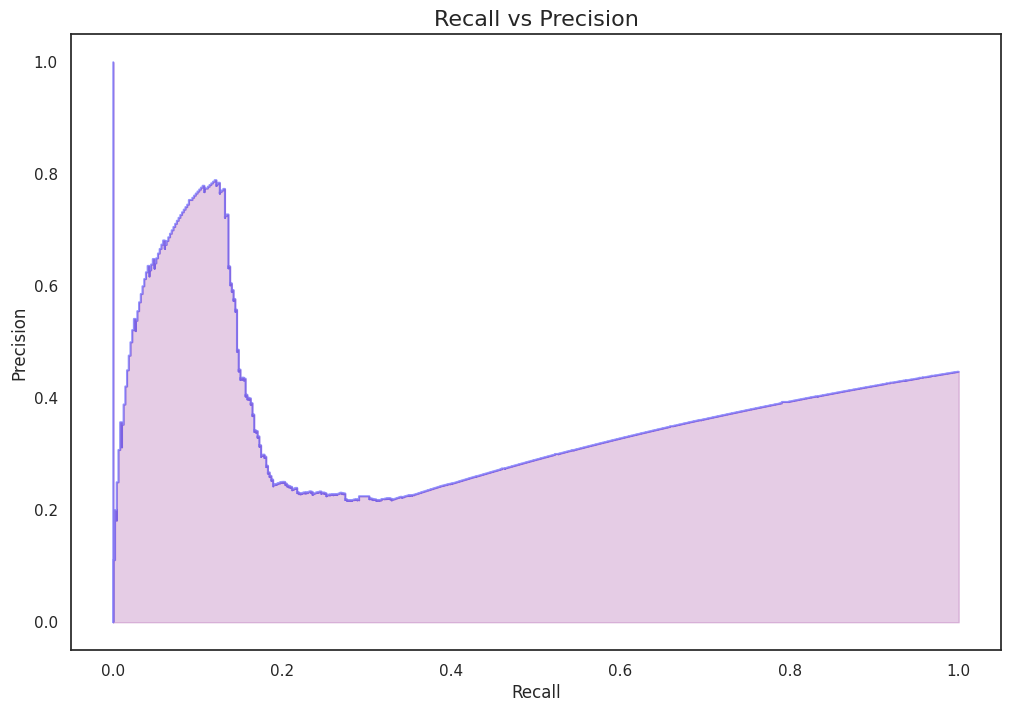

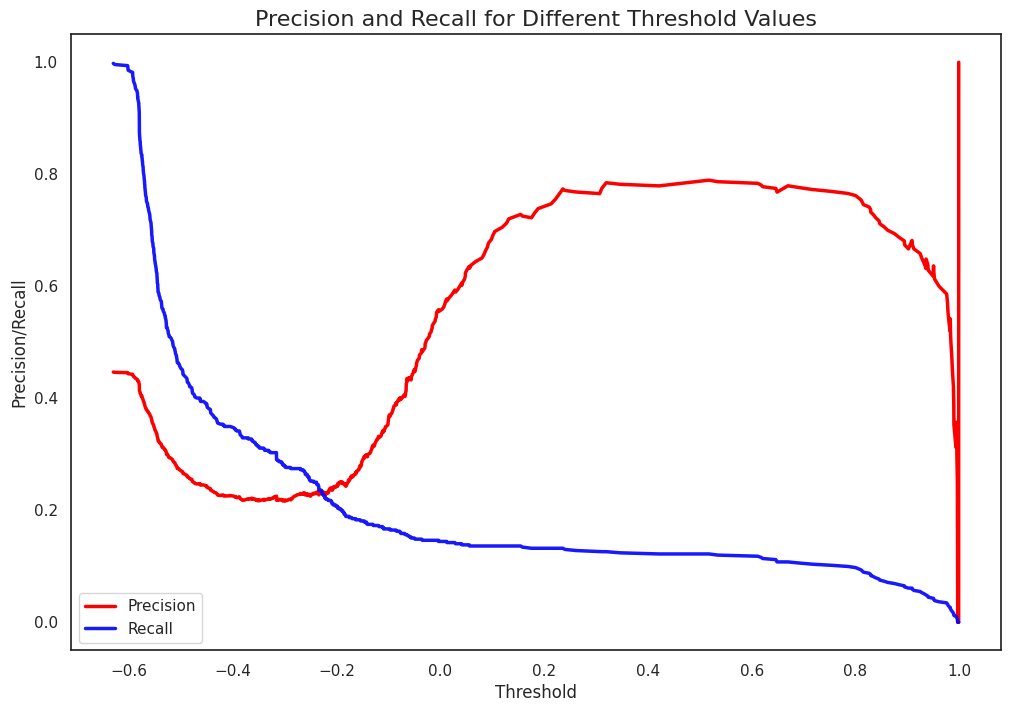

In [ ]:
plot_precision_recall_curves(labels, preds)

**12. Reconstruction Error Plot**

In [ ]:
def reconstruction_error_plot(df, ylims=(None, None), title="Reconstruction error for different classes"):
    groups = df.groupby('Labels_gt')
    sns.set(style="white")
    sns.set_palette(sns.color_palette(["red", "blue"]))
    plt.figure(figsize=(12,8))

    for name, group in groups:
        plt.scatter(group.index,
                    group.Reconstruction_Loss,
                    label="Fraud" if name == 1 else "Normal",
                    alpha=0.7)

    plt.axhline(y=hyper_params['threshold'],
                color='black',
                linestyle='--',
                label='Threshold',
                zorder=100)

    plt.title(title, fontsize=16)
    plt.xlabel("Data point index")
    plt.ylabel("Reconstruction error")
    plt.ylim(top=ylims[0], bottom=ylims[1])

    plt.legend(loc='best')
    plt.tight_layout()

    plt.show()

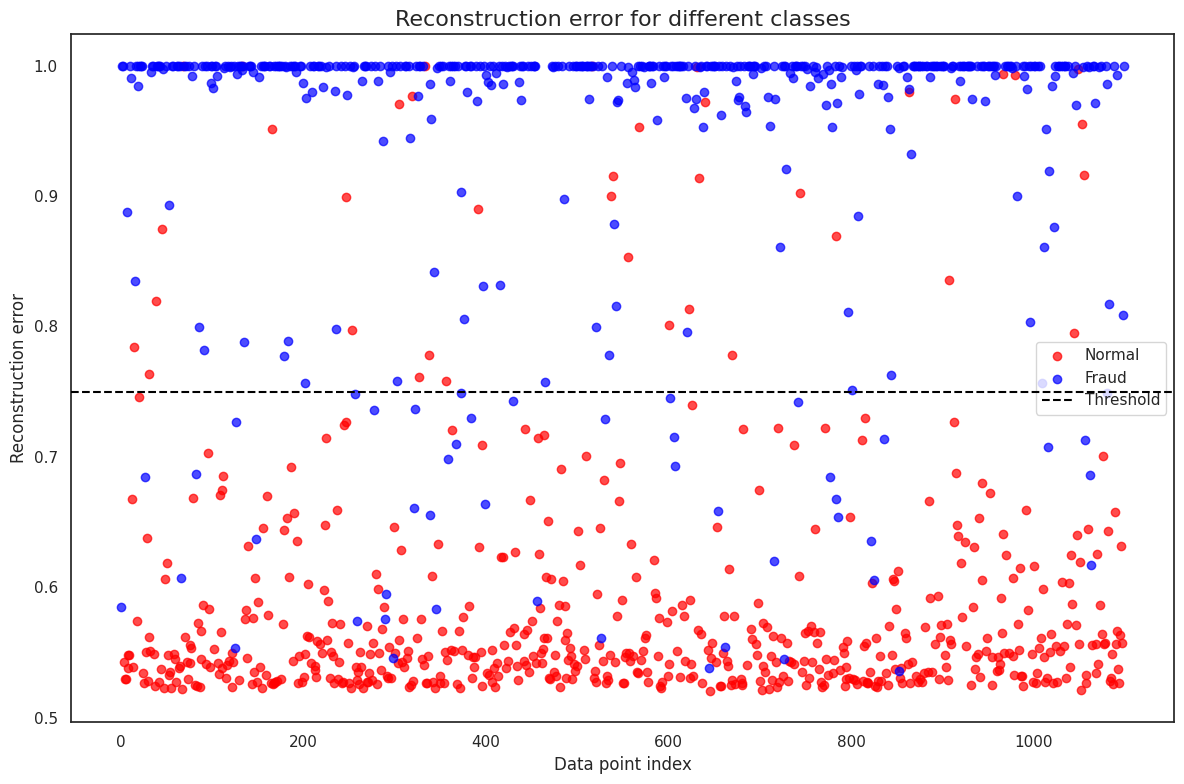

In [ ]:
reconstruction_error_plot(df1)

**5. t-SNE Visualization: Before vs After**

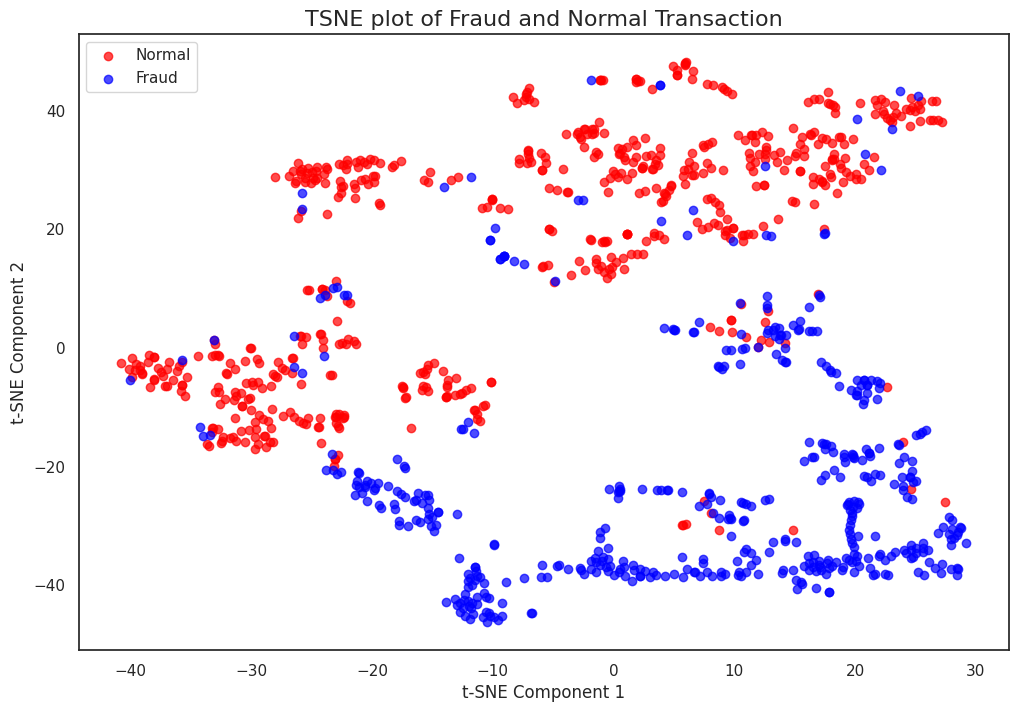

In [ ]:
X1 = np.array(embeds)
y1=np.array(labels)
tsne_plot(X1, y1, name='tsne_plot_autoencoding.png')

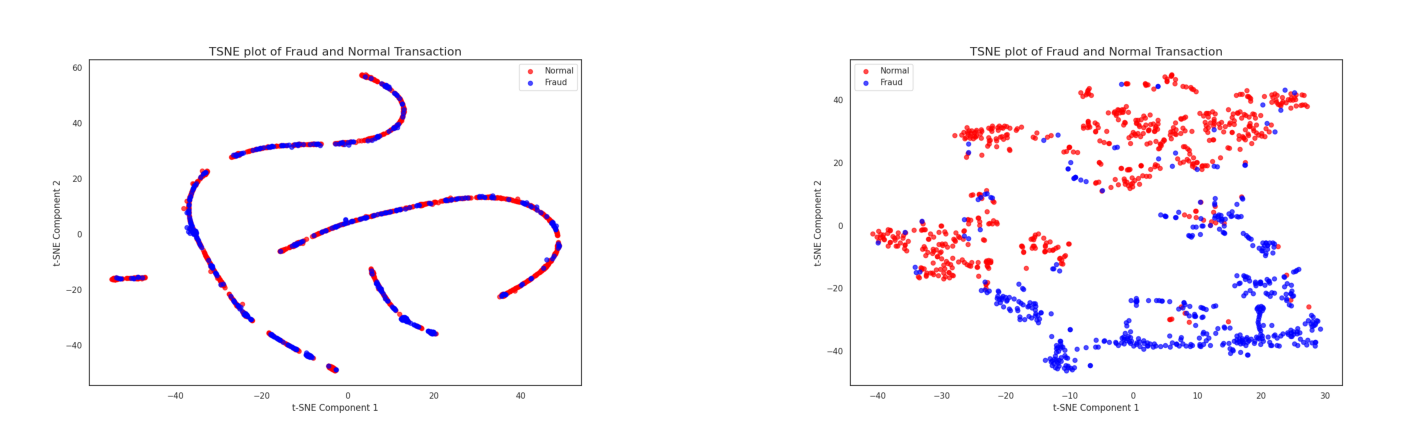

In [ ]:
sns.set(style="white")
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)
plt.imshow(img.imread('tsne_plot.png'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.imread('tsne_plot_autoencoding.png'))
plt.axis('off')

plt.tight_layout
plt.show()

**14. Classification Report and Accuracy**

In [ ]:
print("Classification report \n {0}".format(classification_report(df1.Labels_gt, df1.Labels_preds)))
report = classification_report(df1.Labels_gt, df1.Labels_preds, output_dict=True)
accuracy = report['accuracy']
print(f"Accuracy: {accuracy:.2f}")

Classification report 
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       608
         1.0       0.92      0.90      0.91       492

    accuracy                           0.92      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.92      0.92      0.92      1100

Accuracy: 0.92
